<h1>Содержание<span class="tocSkip"></span></h1>
<div </font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Общий-обзор-данных" data-toc-modified-id="Общий-обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Общий обзор данных</a></span></li><li><span><a href="#Лемматизация-комментариев-и-очистка-текстов-от-лишних-символов" data-toc-modified-id="Лемматизация-комментариев-и-очистка-текстов-от-лишних-символов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация комментариев и очистка текстов от лишних символов</a></span></li><li><span><a href="#Делим-данные-на-выборки" data-toc-modified-id="Делим-данные-на-выборки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Делим данные на выборки</a></span></li><li><span><a href="#Создаем-мешки-слов-и-убираем-стоп-слова" data-toc-modified-id="Создаем-мешки-слов-и-убираем-стоп-слова-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Создаем мешки слов и убираем стоп-слова</a></span></li><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Баланс классов</a></span><ul class="toc-item"><li><span><a href="#F1-с-изменением-весов-в-модели" data-toc-modified-id="F1-с-изменением-весов-в-модели-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>F1 с изменением весов в модели</a></span></li><li><span><a href="#F1-при-ресемплировании-с-уменьшением-класса-0" data-toc-modified-id="F1-при-ресемплировании-с-уменьшением-класса-0-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>F1 при ресемплировании с уменьшением класса 0</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для интернет-магазина

Один интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок:

- `text` - текст комментария;
- `toxic` - целевой признак (1-комментарий токсичен, 0-нетоксичен)

Значение метрики качества *F1* модели должно быть не меньше 0.75. 

## Подготовка

In [ ]:
# импортируем все необходимое
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

### Общий обзор данных

In [ ]:
# сохраним датафрейм в переменную
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
# выведем общую инфо о таблице, посмотрим на наличие пропусков в данных
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
# посмотрим на первые строки
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
# посмотрим, как соотносится кол-во токсичных и нетоксичных комментариев
# создадим табблицу с подсчетом значений каждого класса
ratio_data = toxic_comments.pivot_table(index='toxic', values='text', aggfunc='count')

<AxesSubplot:xlabel='toxic'>

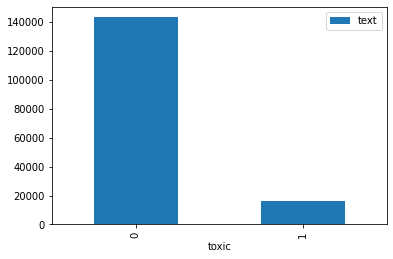

In [ ]:
# построим график
ratio_data.plot.bar()

Как видим, удивительно, но положительных комментариев больше.

In [ ]:
# вычислим соотношение в конкретном числовом виде
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

8.834884437596301

Положительных комментариев почти в 9 раз больше, чем токсичных. Следовательно, баланс классов нарушен, а значит, нам предстоит их сбалансировать на следующих этапах исследования.

### Лемматизация комментариев и очистка текстов от лишних символов

Приведем слова комментариев к леммам. 

In [ ]:
# создадим класс для лемматизации текстов комментариев
m = WordNetLemmatizer() #лемматизация для англоязычных текстов

def lemmatize_text(text):
    # приведем все к единому регистру
    text = text.lower()
    # разбиваем текст на леммы
    lemm_text = "".join(m.lemmatize(text))
    # в лемматизированном тексте комментария нужно оставить только латинские символы и пробелы
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    # функция должна возвращать очищенный и лемматизированный текст без лишних пробелов, т.к. они - помеха для анализа
    return " ".join(cleared_text.split())
# создадим столбец с лемматизированными комментариями
toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)
# удалим исходные тексты
toxic_comments = toxic_comments.drop(['text'], axis=1)

### Делим данные на выборки

In [ ]:
# разобьем данные на выборки: обучающую (80%) и тестовую (20%)
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=12345)

### Создаем мешки слов и убираем стоп-слова

In [ ]:
# преобразуем корпус в мешок слов и очистим тексты от стоп-слов, лишенных смысловой нагрузки
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))
print(features_train.shape)
print(features_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(127656, 148283)
(31915, 148283)


### Баланс классов

Сбалансировать классы можно тремя способами: сократить доминирующий класс выборки, ~~увеличить выборку по "проседающему" классу~~ (почему-то падает ядро, видимо, слишком увеличивается объем выборки и память нагружается?), задать параметр модели `class_weight='balanced'`. 
Попробуем два из трех способов: ресемплирование с уменьшением класса 0 и изменнеие весов в модели обучения, а потом сравним результат метрики F1. 

#### F1 с изменением весов в модели

In [ ]:
%%time

model = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(model, features_train, target_train, cv=3, scoring='f1').mean()
print('F1 на CV со балансированными классами', train_f1_balanced)

F1 на CV со балансированными классами 0.7511776397192941
CPU times: user 33.7 s, sys: 1min 8s, total: 1min 42s
Wall time: 1min 42s


#### F1 при ресемплировании с уменьшением класса 0

In [ ]:
toxic_comments_train = toxic_comments.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [ ]:
target_train_class_zero_downsampled = target_train_class_zero.sample(target_train_class_one.shape[0], random_state=12345)
target_train_downsampled = pd.concat([target_train_class_zero_downsampled, target_train_class_one])

features_train_downsampled = toxic_comments.iloc[target_train_downsampled.index]
features_train_downsampled, target_train_downsampled = shuffle(features_train_downsampled,
                                                               target_train_downsampled,
                                                               random_state=12345)
features_train_downsampled = count_tf_idf.transform(features_train_downsampled['lemm_text'].values.astype('U'))

In [ ]:
target_train_downsampled.value_counts()

0    12986
1    12986
Name: toxic, dtype: int64

In [ ]:
features_train_downsampled.shape

(25972, 148283)

In [ ]:
model = LogisticRegression()
train_f1_downsampled = cross_val_score(model, features_train_downsampled, target_train_downsampled, cv=3, scoring='f1').mean()
print('F1 на CV с уменьшением класса 0', train_f1_downsampled)

F1 на CV с уменьшением класса 0 0.885281783158481


Прирост F1 при уменьшении класса 0 очевиден. Посмотрим на AUC-ROC кривую, чтобы наверняка определиться с вариантом.

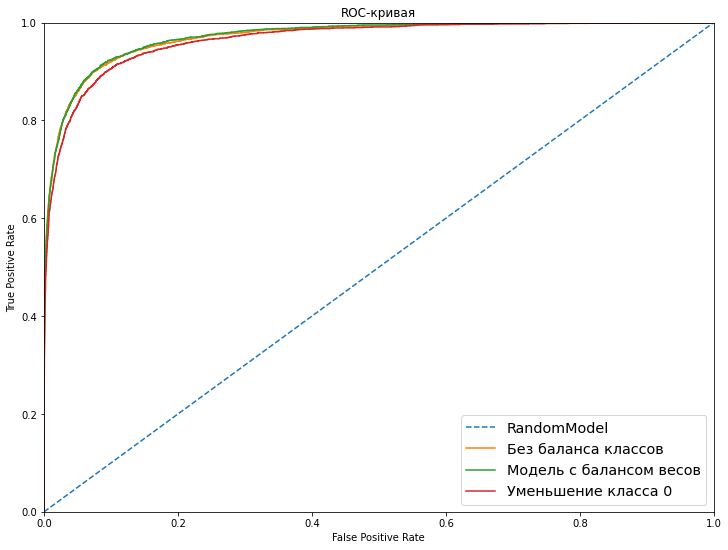

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


clf_mdl = LogisticRegression()
clf_mdl.fit(features_train, target_train)
probabilities_test = clf_mdl.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
test_f1 = f1_score(target_test, clf_mdl.predict(features_test))
plt.plot(fpr, tpr, label='Без баланса классов')

clf_mdl = LogisticRegression(class_weight='balanced')
clf_mdl.fit(features_train, target_train)
probabilities_test = clf_mdl.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_balanced = roc_auc_score(target_test, probabilities_one_test)
test_f1_balanced = f1_score(target_test, clf_mdl.predict(features_test))
plt.plot(fpr, tpr, label='Модель с балансом весов')

clf_mdl = LogisticRegression()
clf_mdl.fit(features_train_downsampled, target_train_downsampled)
probabilities_test = clf_mdl.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc_downsampled = roc_auc_score(target_test, probabilities_one_test)
test_f1_downsampled = f1_score(target_test, clf_mdl.predict(features_test))
plt.plot(fpr, tpr, label='Уменьшение класса 0')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Как видим по графику, площадь под графиком больше всего под линией с балансом классов в модели.

## Обучение

### Модель логистической регрессии 

Через GridSearchCV найдем оптимальные параметры для модели.

In [ ]:
%%time

LogReg_mdl = LogisticRegression(random_state=12345, class_weight='balanced')
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'max_iter':[150, 250, 500]}]

clf = GridSearchCV(LogReg_mdl, hyperparams, scoring='f1',cv=3)
clf.fit(features_train, target_train)
print('Оптимальные параметры:')
LR_best_params = clf.best_params_
print(LR_best_params)

Оптимальные параметры:
{'C': 10, 'max_iter': 150, 'solver': 'lbfgs'}
CPU times: user 12min 41s, sys: 22min 58s, total: 35min 40s
Wall time: 35min 43s


In [ ]:
%%time

LogReg_mdl = LogisticRegression(random_state=12345, solver='lbfgs', C=10, max_iter=250, class_weight='balanced')
LogReg_mdl.fit(features_train, target_train)
LogReg_predictions = LogReg_mdl.predict(features_test)
test_f1_LogReg = f1_score(target_test, LogReg_predictions)

print('F1 на тестовой выборке', test_f1_LogReg)

F1 на тестовой выборке 0.7677875595324001
CPU times: user 41.5 s, sys: 1min 17s, total: 1min 58s
Wall time: 1min 58s


Значение F1 выше порогового в 0.75 - значит модель логистической регрессии с данными параметрами нам подходит для решения поставленной задачи.

### CatBoostClassifier

In [ ]:
CatBoost_mdl = CatBoostClassifier(random_state=12345, verbose=False)
CB_hyperparams = {'iterations': [50, 100, 200]}

In [ ]:
%%time
CB_grid = CatBoost_mdl.grid_search(CB_hyperparams, 
                                   X=features_train, 
                                   y=target_train, 
                                   plot=False)


bestTest = 0.2473678568
bestIteration = 49

0:	loss: 0.2473679	best: 0.2473679 (0)	total: 2m 47s	remaining: 5m 35s

bestTest = 0.2152456351
bestIteration = 99

1:	loss: 0.2152456	best: 0.2152456 (1)	total: 6m 44s	remaining: 3m 22s

bestTest = 0.1914238454
bestIteration = 199

2:	loss: 0.1914238	best: 0.1914238 (2)	total: 14m 30s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.1905171595
bestIteration = 199

Training on fold [1/3]

bestTest = 0.192262273
bestIteration = 199

Training on fold [2/3]

bestTest = 0.1915841477
bestIteration = 199

CPU times: user 41min 3s, sys: 1min 18s, total: 42min 21s
Wall time: 42min 27s


In [ ]:
CatBoost_mdl.get_params()

{'verbose': False, 'random_state': 12345, 'iterations': 200}

In [ ]:
CatBoost_mdl.get_best_score()

{'learn': {'Logloss': 0.11019257351054788}}

In [ ]:
%%time
CatBoost_mdl.fit(features_train, target_train)

CPU times: user 8min 7s, sys: 8.12 s, total: 8min 15s
Wall time: 8min 16s


In [ ]:
%%time
CatBoost_predictions = CatBoost_mdl.predict(features_test)
test_f1_CatBoost = f1_score(target_test, CatBoost_predictions)

print('F1 на тестовой выборке', test_f1_CatBoost)

F1 на тестовой выборке 0.7541337167505392
CPU times: user 358 ms, sys: 17.8 ms, total: 376 ms
Wall time: 385 ms


F1 также выше порогового в 0.75, но чуть хуже, чем у логистической регресии.

### SGDClassifier

In [ ]:
%%time

SGDC_mdl = SGDClassifier()
SGDC_hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12345],
                'class_weight': ['balanced']}]


clf = GridSearchCV(SGDC_mdl, SGDC_hyperparams, scoring='f1', cv=3)
clf.fit(features_train, target_train)
print("Оптимальные параметры:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)

Оптимальные параметры:

{'class_weight': 'balanced', 'eta0': 0.2, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12345}
CPU times: user 3min 22s, sys: 25.5 s, total: 3min 47s
Wall time: 3min 48s


In [ ]:
%%time
SGDC_mdl = SGDClassifier()
SGDC_mdl.set_params(**SGDC_best_params)
SGDC_mdl.fit(features_train, target_train)
SGDC_predictions = SGDC_mdl.predict(features_test)
test_f1_SGDC = f1_score(target_test, SGDC_predictions)

print('F1 на тестовой выборке', test_f1_SGDC)

F1 на тестовой выборке 0.752761489158598
CPU times: user 2.07 s, sys: 125 ms, total: 2.19 s
Wall time: 2.2 s


SGDClassifier нам также подходит для решения задачи. В следующем разделе детальнее посмотрим на метрики моделей.

### Выводы

Выведем таблицу результатов для наглядности.

In [ ]:
index = ['LogisticRegression',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на тестовой выборке':[test_f1_LogReg,
                                  test_f1_CatBoost,
                                  test_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Показатели моделей'] = scores_data['F1 на тестовой выборке'] > 0.75
scores_data

,F1 на тестовой выборке,Показатели моделей
LogisticRegression,0.767788,True
CatBoostClassifier,0.754134,True
SGDClassifier,0.752761,True


## Выводы

Метрики LogisticRegression
ROC AUC: 0.970198741485447
F1: 0.7788710512687727
Precision: 0.8833202819107283
Recall: 0.6965112689101575
Accuracy: 0.9598621337928873

Метрики CatBoostClassifier
ROC AUC: 0.9559020668515014
F1: 0.7541337167505392
Precision: 0.9023655913978494
Recall: 0.6477307811052794
Accuracy: 0.9571361428795238

Метрики SGDClassifier
ROC AUC: 0.9720485542211585
F1: 0.752761489158598
Precision: 0.6741573033707865
Recall: 0.8521148502624267
Accuracy: 0.9431928560238133



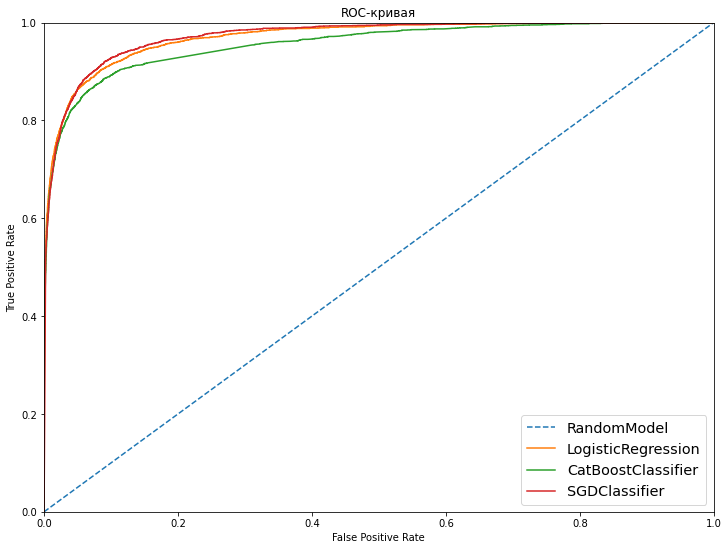

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


LogReg_mdl = LogisticRegression()
LogReg_mdl.set_params(**LR_best_params)
LogReg_mdl.fit(features_train, target_train)
probabilities_test = LogReg_mdl.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = LogReg_mdl.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

CatBoost_mdl = CatBoostClassifier(random_state=12345, iterations=200, verbose=False)
CatBoost_mdl.fit(features_train, target_train)
probabilities_test = CatBoost_mdl.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = CatBoost_mdl.predict(features_test)
plt.plot(fpr, tpr, label='CatBoostClassifier')
print('Метрики CatBoostClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

SGDC_mdl = SGDClassifier()
SGDC_mdl.set_params(**SGDC_best_params)
SGDC_mdl.fit(features_train, target_train)
probabilities_test = SGDC_mdl.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = SGDC_mdl.predict(features_test)
plt.plot(fpr, tpr, label='SGDClassifier')
print('Метрики SGDClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

В рамках проекта мы опробовали для решения задачи классификации три модели:

- Логистическую регрессию;
- CatBoost Classifier;
- SGD Classifier.

В исходных данных наблюдался большой дисбаланс классов, но опытным путем было установлено, что наилучший результат дает способ с изменением весов модели.

Все три модели на тестовой выборке прошли пороговое значение метрики F1 в 0.75, но:
- На тестовой выбоке по метрике F1 лучше всего себя показала LogisticRegression. Данная модель обладает бОльшими показателями Precision и Accuracy. Это говорит нам, что токсичные комментарии находятся лучше.
- У SGDClassifier выше метрика ROC-AUC и Recall.
- CatBoost из всех трех моделей дал худшие показатели.